# Compare the GMST and ocean/atmosphere dynamic sea level anomalies for different scenarios

We investigate here the possibility that GMST is not a good driver for this part of sea level.

This is based on an NCL script: CompTE_GMST.ncl

In [84]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [98]:
DIR_PROJ = '/Users/dewilebars/Projects/Project_ProbSLR/'
DIR_ZOS  = DIR_PROJ+'Project_ProbSLR_archiveKNMIwks/CMIP5_ThermalExp/'
DIR_T    = DIR_PROJ+'Data_Proj/Data_AR5/Tglobal/'

SCE      = 'rcp26'

fzos     = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zos_1986-2100.nc')
fzostoga = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zostoga_1986-2100.nc')
fzossga  = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zossga_1986-2100.nc')
fzos_avg = xr.open_dataset(DIR_ZOS+'CMIP5_SeaLevel_'+SCE+'_zos_avg_1986-2100.nc')

time     = fzos.time
dimt     = len(time)
zos      = np.array(fzos.LocalSeaLevel)
zostoga  = np.array(fzostoga.GlobalSeaLevel)
zossga   = np.array(fzossga.GlobalSeaLevel)
zos_avg  = np.array(fzos_avg.AverageSeaLevel) 
dimzos = zos.shape
print(dimzos)

# Read model names, this need a little function because characters are not read 
#properly by xarray
def read_ModelNames(ds):
    mod_names = []
    for i in range(len(ds.ModelNames)):
        mod_names.append(str(ds.ModelNames[i].values)[2:-1])
    return mod_names
zos_ModelNames     = read_ModelNames(fzos)
zostoga_ModelNames = read_ModelNames(fzostoga)
zossga_ModelNames  = read_ModelNames(fzossga)
zos_avg_ModelNames = read_ModelNames(fzos_avg)

print(zos_ModelNames)

(21, 114)
['bcc-csm1-1', 'bcc-csm1-1-m', 'MIROC-ESM', 'MIROC5', 'MIROC-ESM-CHEM', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'GFDL-ESM2G', 'GFDL-ESM2M', 'NorESM1-M', 'NorESM1-ME', 'CCSM4', 'FGOALS-g2', 'HadGEM2-ES', 'CSIRO-Mk3-6-0', 'CanESM2', 'GISS-E2-R', 'MRI-CGCM3', 'MPI-ESM-LR', 'MPI-ESM-MR', 'CNRM-CM5']


In [99]:
### Combine global and regional sea level change

glob_sl = np.zeros(zos.shape)
for m in range(0,dimzos[0]):
    try:
        inds = zostoga_ModelNames.index(zos_ModelNames[m])
        glob_sl[m,:]  = zostoga[inds,:]
        print('Using '+zos_ModelNames[m]+' with zostoga for global')
    except:
        try:
            inds = zossga_ModelNames.index(zos_ModelNames[m])
            glob_sl[m,:]  = zossga[inds,:]
            print("Using "+zos_ModelNames[m]+' with zossga for global')
        except:
            print("No global steric data for "+zos_ModelNames[m])
            glob_sl[m,:] = np.nan
    try:
        inds = zos_avg_ModelNames.index(zos_ModelNames[m])
        glob_sl[m,:] = glob_sl[m,:] - zos_avg[inds,:]
    except:
        print('Missing zos_avg for model '+zos_ModelNames[m])

tot_sl  = zos + glob_sl
        
ind_s1 = np.where(time==1986.5)[0][0]
ind_e1 = np.where(time==2005.5)[0][0]
ind_s2 = np.where(time==2091.5)[0][0] # 2081.5
ind_e2 = np.where(time==2099.5)[0][0]

tot_sl_avg1  = tot_sl[:,ind_s1:ind_e1+1].mean(axis=1)
tot_sl_avg2  = tot_sl[:,ind_s2:ind_e2+1].mean(axis=1)
glob_sl_avg1 = glob_sl[:,ind_s1:ind_e1+1].mean(axis=1)
glob_sl_avg2 = glob_sl[:,ind_s2:ind_e2+1].mean(axis=1)

Delta_tot_sl  = tot_sl_avg2 - tot_sl_avg1
Delta_glob_sl = glob_sl_avg2 - glob_sl_avg1

Using bcc-csm1-1 with zostoga for global
Using bcc-csm1-1-m with zostoga for global
Using MIROC-ESM with zostoga for global
Using MIROC5 with zostoga for global
Using MIROC-ESM-CHEM with zostoga for global
Using IPSL-CM5A-LR with zostoga for global
Using IPSL-CM5A-MR with zostoga for global
Using GFDL-ESM2G with zossga for global
Using GFDL-ESM2M with zossga for global
Using NorESM1-M with zostoga for global
Using NorESM1-ME with zostoga for global
Using CCSM4 with zostoga for global
No global steric data for FGOALS-g2
Using HadGEM2-ES with zostoga for global
Using CSIRO-Mk3-6-0 with zostoga for global
Using CanESM2 with zostoga for global
Using GISS-E2-R with zostoga for global
Using MRI-CGCM3 with zostoga for global
Using MPI-ESM-LR with zostoga for global
Using MPI-ESM-MR with zostoga for global
Using CNRM-CM5 with zostoga for global


In [100]:
# Read temperature
temp  = np.zeros(dimzos)
temp_avg1 = np.zeros(dimzos[0])
temp_avg2 = np.zeros(dimzos[0])
col_names = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
             'Sep', 'Oct', 'Nov', 'Dec']
for m in range(dimzos[0]):
    print('Reading temperature for '+zos_ModelNames[m])
    file_name = 'global_tas_Amon_'+zos_ModelNames[m]+'_'+SCE+'_r1i1p1.dat'
    try:
        TEMP = pd.read_csv(DIR_T+file_name, comment='#', delim_whitespace=True, \
                           names=col_names)
        timeT = TEMP['Year'][:]
        TEMPy = TEMP.iloc[:,1:].mean(axis=1) # Compute yearly averages
        ind_s1 = np.where(timeT==1986)[0][0]
        ind_e1 = np.where(timeT==2005)[0][0]
        ind_s2 = np.where(timeT==2091)[0][0]
        ind_e2 = np.where(timeT==2099)[0][0]
        temp_avg1[m] = TEMPy[ind_s1:ind_e1+1].mean()
        temp_avg2[m] = TEMPy[ind_s2:ind_e2+1].mean()
        del(TEMP)
        del(timeT)
        del(TEMPy)
    except:
        print('Temperature file missing for: '+zos_ModelNames[m])
        temp_avg1[m] = np.nan
        temp_avg2[m] = np.nan


Reading temperature for bcc-csm1-1
Reading temperature for bcc-csm1-1-m
Reading temperature for MIROC-ESM
Reading temperature for MIROC5
Reading temperature for MIROC-ESM-CHEM
Reading temperature for IPSL-CM5A-LR
Reading temperature for IPSL-CM5A-MR
Reading temperature for GFDL-ESM2G
Reading temperature for GFDL-ESM2M
Reading temperature for NorESM1-M
Reading temperature for NorESM1-ME
Reading temperature for CCSM4
Reading temperature for FGOALS-g2
Temperature file missing for: FGOALS-g2
Reading temperature for HadGEM2-ES
Reading temperature for CSIRO-Mk3-6-0
Reading temperature for CanESM2
Reading temperature for GISS-E2-R
Reading temperature for MRI-CGCM3
Reading temperature for MPI-ESM-LR
Reading temperature for MPI-ESM-MR
Reading temperature for CNRM-CM5


In [101]:

Delta_temp    = temp_avg2 - temp_avg1

print(Delta_glob_sl)

[ 0.10906015  0.08844789  0.05701888  0.19399667  0.12368641  0.21305368
  0.1939541   0.11576963  0.14145447 -0.00091578 -0.00149908  0.13900689
         nan  0.10011796  0.16586857  0.15616132  0.02430253  0.09798653
  0.13499485  0.11864899 -0.00121616]


In [102]:
# Compute correlations
# print('Pearson correlation between local sea level and GMST:')
# print(scipy.stats.pearsonr(Delta_temp, Delta_tot_sl))
# print('Pearson correlation between global mean sea level and GMST:')
# print(scipy.stats.pearsonr(Delta_temp, Delta_glob_sl))

df = pd.DataFrame({'GMST':Delta_temp, 'GMSL':Delta_glob_sl, 'RegSL':Delta_tot_sl})
rho = df.corr()
rho

,GMST,GMSL,RegSL
GMST,1.000000,0.191925,0.715208
GMSL,0.191925,1.000000,0.222987
RegSL,0.715208,0.222987,1.000000


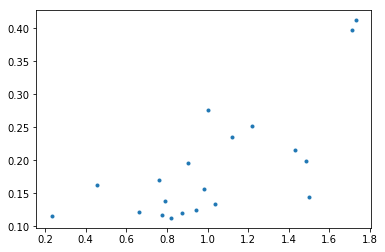

In [103]:
# Plot
fig, ax = plt.subplots()
ax.plot(Delta_temp, Delta_tot_sl, '.')

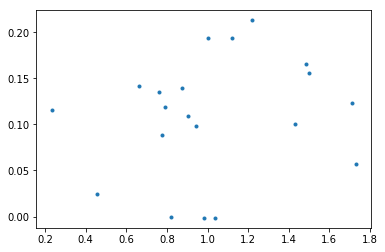

In [104]:
fig, ax = plt.subplots()
ax.plot(Delta_temp, Delta_glob_sl, '.')

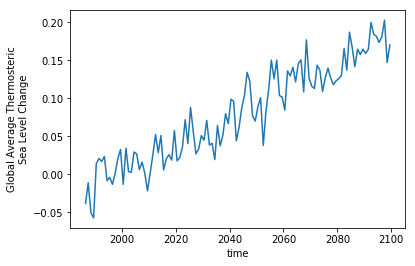

In [82]:
fzos.LocalSeaLevel[11,:].plot()